# 불량품 예측

불량품을 예측하기 위해 다음과 같은 함수화 정리를 진행한다. 혼란을 막기 위해 모든 과정을 함수화 하기로 한다.  
목차는 다음과 같다.

- 1. Load packages & Data
- 2. Function

## 1. Load Packages & Data

In [1]:
### ide packages
import os
from pprint import pprint
import numpy as np
import pandas as pd
import random
import string
from tqdm import tqdm

# sklearn preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

# models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, plot_metric
from xgboost import XGBClassifier
import lightgbm as lgb

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# tuning
import optuna

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
load_dir = './data/'
train = pd.read_csv(load_dir + "train.csv")
test = pd.read_csv(load_dir + "test.csv")

## 2. Functions

In [3]:
# 평가 스코어 지정하기
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

# 평가 매트릭 계산 결과 보여주기
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 해당 공정 맞춤형 위치 옮기기
def move_data(data):
    # divide
    dam = data.filter(regex='_Dam')
    fill1 = data.filter(regex='_Fill1')
    fill2 = data.filter(regex='_Fill2')
    autoclave = data.filter(regex='_AutoClave')
    target = data['target']

    # dam
    dam = dam.dropna(axis=1, how='all')
    dam = dam.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam')
    dam_mask = dam[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
    dam = dam.drop(columns='WorkMode Collect Result_Dam')

    # fill1
    fill1 = fill1.dropna(axis=1, how='all')
    fill1 = fill1.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1')
    fill1_mask = fill1[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan])].iloc[:, 14:].shift(-1, axis = 1).values
    fill1.loc[fill1['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].isin(['OK', np.nan]), fill1.columns[14:]] = fill1_mask
    fill1 = fill1.drop(columns='WorkMode Collect Result_Fill1')

    # fill2
    fill2 = fill2.dropna(axis=1, how='all')
    fill2 = fill2.drop(columns='HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2')
    fill2_mask = fill2[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan])].iloc[:, 24:].shift(-1, axis = 1).values
    fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
    fill2 = fill2.drop(columns='WorkMode Collect Result_Fill2')

    # CONCAT
    data = pd.concat([dam, fill1, fill2, autoclave, target], axis=1)
    
    return data

In [5]:
# 칼럼 위치 변경
def swap_columns(df, condition, col1, col2):
    # 조건에 해당하는 행 필터링
    filtered_df = df[condition]
    
    # 값 교환
    df.loc[condition, [col1, col2]] = filtered_df[[col1, col2]].copy().iloc[:, ::-1].values

    return df

In [6]:
# Equipment 방향 통일과 잘못된 위치 재조정하기
def change_data(train, test):
    # train
    train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    X_sum_down_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_down_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    X_sum_up_1 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    X_sum_up_2 = train[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    X_sum_down = (X_sum_down_1 - X_sum_down_2) / 2 # stage1에서 빼고, Stage3에서 더하기 <500
    X_sum_up = (X_sum_up_2 - X_sum_up_1) / 2 # stage1에서 더하고, Stage 3에서 빼기

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    train.loc[train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # test
    test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)
    test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float)


    # 이동 전
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] += X_sum_up
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] -= X_sum_up

    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] -= X_sum_down
    test.loc[test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) < 500, 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'] += X_sum_down

    # train
    Y_sum_dam_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']

    Y_sum_dam_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']

    Y_sum_dam_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()
    Y_sum_dam_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']

    Y_sum_fill_1 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_2 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']

    Y_sum_fill_3 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_4 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float).mean()

    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    Y_sum_fill_5 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    Y_sum_fill_6 = train[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) < 500]['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float).mean()
    train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - train.loc[train['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']

    # test
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'] = Y_sum_dam_1 + Y_sum_dam_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'] = Y_sum_dam_5 + Y_sum_dam_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'] = Y_sum_dam_3 + Y_sum_dam_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'] = Y_sum_fill_1 + Y_sum_fill_2 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'] = Y_sum_fill_5 + Y_sum_fill_6 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1']
    test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'] = Y_sum_fill_3 + Y_sum_fill_4 - test.loc[test['HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'].astype(float) > 500, 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1']

    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(train, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(train, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')


    ### Test
    # 조건을 만족하는 행 인덱스를 찾음
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'].astype(float) >= 200

    # DISCHARGED TIME OF RESIN(Stage1) 
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Dam', 'Dispense Volume(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam')

    # Stage1 Circle1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Circle1 Distance Speed Collect Result_Dam', 'Stage3 Circle1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle2 Distance Speed Collect Result_Dam', 'Stage3 Circle2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle3 Distance Speed Collect Result_Dam', 'Stage3 Circle3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Circle4 Distance Speed Collect Result_Dam', 'Stage3 Circle4 Distance Speed Collect Result_Dam')

    # Stage1 Line1 Distance Speed Collect
    swap_columns(test, condition, 'Stage1 Line1 Distance Speed Collect Result_Dam', 'Stage3 Line1 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line2 Distance Speed Collect Result_Dam', 'Stage3 Line2 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line3 Distance Speed Collect Result_Dam', 'Stage3 Line3 Distance Speed Collect Result_Dam')
    swap_columns(test, condition, 'Stage1 Line4 Distance Speed Collect Result_Dam', 'Stage3 Line4 Distance Speed Collect Result_Dam')

    # THICKNESS 1
    # swap_columns(train, condition, 'THICKNESS 1 Collect Result_Dam', 'THICKNESS 3 Collect Result_Dam')

    ### 젤 마지막에 와야됨!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam')
    
    ### Train
    # 조건을 만족하는 행 인덱스를 찾음
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float) < 200

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1')
    
    ### Train
    condition = train['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(train, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(train, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(train, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    ### Test
    condition = test['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'].astype(float) > 500

    # DISCHARGED TIME OF RESIN(Stage1)
    swap_columns(test, condition, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1')

    # Dispense Volume(Stage1)
    swap_columns(test, condition, 'Dispense Volume(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Y AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1')

    # HEAD NORMAL COORDINATE Z AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1')

    # 반드시 마지막으로 와야함!!!!
    # HEAD NORMAL COORDINATE X AXIS(Stage1)
    swap_columns(test, condition, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1')

    return train, test

In [7]:
# Dam, Fill1, Fill2에서 지정된 값이 다를 경우 Abnormal 
def inconsistant(data, columnname, iwantthiscolumnsname, is_train = True):
    # 장비 번호가 다르면 불일치
    if is_train:
        cri = [
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill1'],
            df_train[columnname + '_Dam'] != df_train[columnname + '_Fill2'],
            df_train[columnname + '_Fill1'] != df_train[columnname + '_Fill2'],
            data[iwantthiscolumnsname] == 1
        ]
        
    else:
        cri = [
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill1'],
            df_test[columnname + '_Dam'] != df_test[columnname + '_Fill2'],
            df_test[columnname + '_Fill1'] != df_test[columnname + '_Fill1'],
            data[iwantthiscolumnsname] == 1
        ]
    con = [1, 1, 1, 1]

    data[iwantthiscolumnsname] = np.select(cri, con, default = 0)

In [8]:
# 변수 세팅
def variable_setting(types, tr, te, columns_to_convert, columns_to):
    train = tr.copy()
    test = te.copy()
    
    if types == 'catboost':
        dtype = 'string'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'lightgbm':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)

        dtype = 'category'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    elif types == 'xgboost':
        dtype = 'float'  # 원하는 데이터 타입
        for column in columns_to_convert + columns_to:
            train[column] = train[column].astype(dtype)
            test[column] = test[column].astype(dtype)
            
    return train, test

In [9]:
def model_best_threshold(model, X_valid, y_valid):
    # Precision - Recall
    y_pred_proba = model.predict_proba(X_valid)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
    f1_scores = 2*recall*precision / (recall + precision)
    cat_best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
    
    return thresholds, y_pred_custom_threshold

In [10]:
def xgboost_optuna(train, cat_features_indices):
    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        }

        model = xgb.XGBClassifier(eval_metric='logloss', **params)

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [11]:
def lightgbm_optuna(train, cat_features_indices):

    X = train.drop(columns=['target'])
    y = train['target']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(trial):
        lgbm_params = {
            'n_estimators': trial.suggest_int('n_estimators', 400, 1500),
            "max_depth": trial.suggest_int('max_depth', 3, 63),
            "learning_rate": trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True), 
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_float('min_child_weight', 0.5, 4),
            "min_child_samples": trial.suggest_int('min_child_samples', 5, 100),
            "subsample": trial.suggest_float('subsample', 0.4, 1),
            "subsample_freq": trial.suggest_int('subsample_freq', 0, 5),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.2, 1),
            'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        }

        model = LGBMClassifier(**lgbm_params, device='cpu', random_state=42, verbose=-1)

        # 범주형 피처 적용
        model.fit(X_train, y_train, categorical_feature=cat_features_indices)

        # 검증 데이터에서 예측 수행
        y_pred = model.predict(X_valid)

        # F1 점수 계산
        f1 = f1_score(y_valid, y_pred)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

In [12]:
def catboost_optuna(train, cat_features_indices):
    
    # train X, y
    X = train.drop(columns=['target'])
    y = train['target']

    # $plit 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pooling
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices)
    
    # tuning parameters
    def objective(trial):
        # 하이퍼파라미터를 샘플링
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            "od_wait": trial.suggest_int("od_wait", 10, 50),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
            "verbose": 0,
            "random_seed": 42
        }

        # CatBoost 모델 학습
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

        # 검증 세트에 대한 예측 및 평가
        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds)

        return f1

    # Optuna 스터디 생성 및 최적화
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=12)

    # 최적의 하이퍼파라미터 출력
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    return study.best_trial.params, X, y, X_train.index, X_valid.index

## 3. Setting

In [13]:
# 기준
columnname = ['Equipment', 'Receip No Collect Result', 'Production Qty Collect Result', 'PalletID Collect Result', ]

In [14]:
# drop oolumns
drop_col = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam', 
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam', 
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    
    # Dam, Fill2의 경우 Z값이 서로 같다. -> 그렇다면 Fill1은 높이값에서 흔들린 경우가 있다는 것을 의미한다.
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    
    # 의미를 찾을 수 없는 컬럼들 제거
    'Wip Line_Fill1', 
    'Process Desc._Fill1', 
    'Insp. Seq No._Fill1', 
    'Insp Judge Code_Fill1', 
    'Equipment_AutoClave',
    'Process Desc._AutoClave', 
    'Wip Line_AutoClave', 
    'Insp Judge Code_AutoClave',
    'Insp. Seq No._AutoClave',
    '1st Pressure Judge Value_AutoClave', 
    '2nd Pressure Judge Value_AutoClave', 
    '3rd Pressure Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'Wip Line_Fill2', 
    'Process Desc._Fill2', 
    'Insp. Seq No._Fill2', 
    'Insp Judge Code_Fill2', 
    'Wip Line_Dam', 
    'Process Desc._Dam', 
    'Insp. Seq No._Dam', 
    'Insp Judge Code_Dam',
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE STANDBY POSITION X Collect Result_Dam',
    'CURE STANDBY POSITION Z Collect Result_Dam',
    'CURE STANDBY POSITION Θ Collect Result_Dam',
    
    # Fill2는 레진을 살포하지 않는다. UV만 진행하는 과정이므로 싹 삭제해 준다.          
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2',
    'Dispense Volume(Stage1) Collect Result_Fill2',
    'Dispense Volume(Stage2) Collect Result_Fill2',
    'Dispense Volume(Stage3) Collect Result_Fill2',
    
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam',
    
    # 단일값이 하나인 컬럼들, 의미를 찾고싶다면 주석처리 해야하는 것들
    'CURE START POSITION X Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'CURE START POSITION Z Collect Result_Dam', # START POSITION
    'CURE START POSITION Θ Collect Result_Dam', # Equipment에 따라서 정해지며, 하나로 책정됨.
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam', # 흔들림에 따라 Z
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    
    # AutoClave 의미없어보이는거 제거
    'Chamber Temp. Judge Value_AutoClave',
#     'Chamber Temp. Unit Time_AutoClave',
#     '1st Pressure_AutoClave',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
    
    # Model.Suffix, Workorder이 같다.
    'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 'Model.Suffix_AutoClave',
    'Workorder_Fill1', 'Workorder_Fill2', 'Workorder_AutoClave',
    
    # 아무 의미 없는 값
    'Chamber Temp. Judge Value_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Unit Time_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    
    # 중복 데이터 없애기
    'PalletID Collect Result_Fill1', 
    'Production Qty Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'PalletID Collect Result_Fill2', 
    'Production Qty Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
    'Equipment_Fill1',
    'Equipment_Fill2'
]

## 4. Matched Data

In [15]:
# 위치 옮기기
train_move = move_data(train)
test_move = move_data(test)

/tmp/ipykernel_998/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dam.loc[dam['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].isin(['OK', np.nan]), dam.columns[24:]] = dam_mask
/tmp/ipykernel_998/691509256.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fill2.loc[fill2['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].isin(['OK', np.nan]), fill2.columns[24:]] = fill2_mask
/tmp/ipykernel_998/691509256.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '

In [16]:
# 위치 변경 및 Equipment2 를 Equipment1 방향으로 변경
df_train, df_test = change_data(train_move, test_move)

### Type Change

In [17]:
# 데이터 타입 변경하기
type_change = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1']

for i in type_change:
    df_train[i] = df_train[i].astype('float64')
    df_test[i] = df_test[i].astype('float64')

### Modified Equipment data type

In [18]:
# Equipment 번호만 가져오기
df_train['Equipment_Dam'] = df_train['Equipment_Dam'].str.slice(15, 16)
df_train['Equipment_Fill1'] = df_train['Equipment_Fill1'].str.slice(17, 18)
df_train['Equipment_Fill2'] = df_train['Equipment_Fill2'].str.slice(17, 18)

df_test['Equipment_Dam'] = df_test['Equipment_Dam'].str.slice(15, 16)
df_test['Equipment_Fill1'] = df_test['Equipment_Fill1'].str.slice(17, 18)
df_test['Equipment_Fill2'] = df_test['Equipment_Fill2'].str.slice(17, 18)

### New Column

In [19]:
# 불일치 변수
df_train['inconsistant'] = 0
df_test['inconsistant'] = 0

# 장착
for i in columnname:
    inconsistant(df_train, i, 'inconsistant', True)
    inconsistant(df_test, i, 'inconsistant', False)

In [20]:
# 시간이 0이하, 900이상인 값은 이상치로 분류
for j in ['Machine Tact time Collect Result_Dam', 'Machine Tact time Collect Result_Fill1', 'Machine Tact time Collect Result_Fill2']:
    cri = [
        df_train[j] <= 0,
        df_train[j] > 900
    ]
    cri2 = [
        df_test[j] <= 0,
        df_test[j] > 900
    ]
    con = [
        1, 1
    ]
    df_train['inconsistant'] = np.select(cri, con, default = df_train['inconsistant'])
    df_test['inconsistant'] = np.select(cri2, con, default = df_test['inconsistant'])

### Speed Line & Circle

In [21]:
# 라인별로 속도가 같아야 정상이다.
df_train['Stage1 Line diffent Distance Speed_Dam'] = ((df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage1 Line Sum Speed_Dam'] = df_train['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage1 Line4 Distance Speed Collect Result_Dam']

df_train['Stage2 Line diffent Distance Speed_Dam'] = ((df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage2 Line Sum Speed_Dam'] = df_train['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage2 Line4 Distance Speed Collect Result_Dam']

df_train['Stage3 Line diffent Distance Speed_Dam'] = ((df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_train['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_train['Stage3 Line Sum Speed_Dam'] = df_train['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_train['Stage3 Line4 Distance Speed Collect Result_Dam']


In [22]:
# 라인별로 속도가 같아야 정상이다.
df_test['Stage1 Line diffent Distance Speed_Dam'] = ((df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage1 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage1 Line Sum Speed_Dam'] = df_test['Stage1 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage1 Line4 Distance Speed Collect Result_Dam']

df_test['Stage2 Line diffent Distance Speed_Dam'] = ((df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage2 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage2 Line Sum Speed_Dam'] = df_test['Stage2 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage2 Line4 Distance Speed Collect Result_Dam']

df_test['Stage3 Line diffent Distance Speed_Dam'] = ((df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line2 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line3 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam']) |
                                                  (df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] != df_test['Stage3 Line4 Distance Speed Collect Result_Dam'])).astype(int)
df_test['Stage3 Line Sum Speed_Dam'] = df_test['Stage3 Line1 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line2 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line3 Distance Speed Collect Result_Dam'] + df_test['Stage3 Line4 Distance Speed Collect Result_Dam']

### Columns Drop

In [23]:
# 수많은 칼럼 버리기
df_train = df_train.drop(columns = drop_col, axis = 1)
df_test = df_test.drop(columns = drop_col, axis = 1)

### Type 수정

In [24]:
label_encoders = {}
categorical_features = ['Workorder_Dam', 'Model.Suffix_Dam']

# 시드 설정
np.random.seed(42)
for feature in categorical_features:
    le = LabelEncoder()
    df_train[feature] = le.fit_transform(df_train[feature])
    
    # 검증 데이터에 있는 새로운 값에 대해 처리
    unique_values = set(df_test[feature].unique()) - set(le.classes_)
    if unique_values:
        # 새로운 값들을 인코딩할 무작위 숫자 생성
        new_labels = np.random.randint(0, len(le.classes_), size=len(unique_values))
        # 새로운 값들을 인코딩
        le.classes_ = np.append(le.classes_, list(unique_values))
        le.transform(list(unique_values))  # transform을 호출해서 classes_ 업데이트
    
    df_test[feature] = le.transform(df_test[feature])
    label_encoders[feature] = le

### time 보정

In [25]:
# time 보정하기
df_train['rount_1st_time'] = round(df_train['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_train['rount_2nd_time'] = round(df_train['2nd Pressure Unit Time_AutoClave'], -1)
df_train['rount_3rd_time'] = round(df_train['3rd Pressure Unit Time_AutoClave'], -1)
df_train['all_time'] = round(df_train['Chamber Temp. Unit Time_AutoClave'], -1)

df_test['rount_1st_time'] = round(df_test['1st Pressure 1st Pressure Unit Time_AutoClave'], -1)
df_test['rount_2nd_time'] = round(df_test['2nd Pressure Unit Time_AutoClave'], -1)
df_test['rount_3rd_time'] = round(df_test['3rd Pressure Unit Time_AutoClave'], -1)
df_test['all_time'] = round(df_test['Chamber Temp. Unit Time_AutoClave'], -1)

time_col = [
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
    'Chamber Temp. Unit Time_AutoClave'
]

# 적용
df_train = df_train.drop(columns = time_col, axis = 1)
df_test = df_test.drop(columns = time_col, axis = 1)

### target 0, 1 변환

In [26]:
df_train['target'] = np.where(df_train['target'] == 'Normal', 0, 1)

## 4.5 Dam, Fill, AutoClave 단계마다 적용할 변수 기초 만들기

In [27]:
df_train.columns

Index(['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'CURE SPEED Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
       'Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'Head Clean Position Z 

In [28]:
first_col = [
    'Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
    'CURE SPEED Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Machine Tact time Collect Result_Dam', 'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'THICKNESS 1 Collect Result_Dam', 'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam',
    'inconsistant',
    'Stage1 Line diffent Distance Speed_Dam', 'Stage1 Line Sum Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam', 'Stage2 Line Sum Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam', 'Stage3 Line Sum Speed_Dam'
]

second_col = [
    'Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
    'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam',
    'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'Machine Tact time Collect Result_Fill1',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'Machine Tact time Collect Result_Fill2', 'inconsistant'
]

last_col = [
    'Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
    'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam', 'Receip No Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave', 'inconsistant',
    '1st Pressure Collect Result_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    'rount_1st_time', 'rount_2nd_time', 'rount_3rd_time', 'all_time'
    
]

In [29]:
# Dam
first_train = df_train[first_col]
first_test = df_test[first_col]
first_train['target'] = df_train['target']

# Fill
second_train = df_train[second_col]
second_test = df_test[second_col]
second_train['target'] = df_train['target']

# autoclave
last_train = df_train[last_col]
last_test = df_test[last_col]
last_train['target'] = df_train['target']

/tmp/ipykernel_998/1848517664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_train['target'] = df_train['target']
/tmp/ipykernel_998/1848517664.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_train['target'] = df_train['target']
/tmp/ipykernel_998/1848517664.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

## 5. 데이터 학습하기


### setting

In [30]:
# 변환 리스트
columns_to_convert = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Workorder_Dam',
    'Model.Suffix_Dam'
]  

# 변환할 컬럼명 리스트
columns_to = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam'
]

In [31]:
cat_features_indices = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to

In [32]:
# data
cat_train, cat_test = variable_setting('catboost', df_train, df_test, columns_to_convert, columns_to)
lgbm_train, lgbm_test = variable_setting('lightgbm', df_train, df_test, columns_to_convert, columns_to)
xgb_train, xgb_test = variable_setting('xgboost', df_train, df_test, columns_to_convert, columns_to)

### Best_Params 얻기

In [33]:
# optuna tuning
cat_best_params, X_cat, y_cat, cat_train_index, cat_valid_index = catboost_optuna(cat_train, cat_features_indices)

[I 2024-08-19 14:03:10,074] A new study created in memory with name: no-name-d1e2a0ab-314d-40ad-9dea-cc95accaccd7
[I 2024-08-19 14:03:28,949] Trial 0 finished with value: 0.14198782961460446 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.14198782961460446.
[I 2024-08-19 14:03:55,678] Trial 1 finished with value: 0.06751054852320675 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.14198782961460446.
[I 2024-08-19 14:05:07,140] Trial 2 finished with value: 0.

Best trial:
  Value: 0.14198782961460446
  Params: 
    iterations: 437
    depth: 10
    learning_rate: 0.15702970884055384
    l2_leaf_reg: 5.990598257128395
    border_count: 66
    random_strength: 1.559945204206032
    bagging_temperature: 0.05808361216819946
    od_type: IncToDec
    od_wait: 39
    boosting_type: Plain


In [34]:
# optuna tuning
lgbm_best_params, X_lgbm, y_lgbm, lgbm_train_index, lgbm_valid_index = lightgbm_optuna(lgbm_train, cat_features_indices)

[I 2024-08-19 14:07:51,885] A new study created in memory with name: no-name-1040f6f1-fc47-4b1e-a5fa-9d573189dfd2
[I 2024-08-19 14:07:54,609] Trial 0 finished with value: 0.06751054852320675 and parameters: {'n_estimators': 812, 'max_depth': 60, 'learning_rate': 0.0029106359131330704, 'reg_alpha': 0.24810409748678125, 'reg_lambda': 0.004207988669606638, 'min_child_weight': 1.0459808211767092, 'min_child_samples': 10, 'subsample': 0.9197056874649611, 'subsample_freq': 3, 'colsample_bytree': 0.7664580622368364, 'num_leaves': 3}. Best is trial 0 with value: 0.06751054852320675.
[I 2024-08-19 14:07:58,083] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1467, 'max_depth': 53, 'learning_rate': 0.00026587543983272726, 'reg_alpha': 0.005337032762603957, 'reg_lambda': 0.00541524411940254, 'min_child_weight': 1.564847850358382, 'min_child_samples': 55, 'subsample': 0.6591670111852694, 'subsample_freq': 1, 'colsample_bytree': 0.6894823157779035, 'num_leaves': 10}. Best is trial

Best trial:
  Value: 0.14056224899598393
  Params: 
    n_estimators: 1325
    max_depth: 43
    learning_rate: 0.009871149613069051
    reg_alpha: 0.028967847134875147
    reg_lambda: 0.0010048404716309263
    min_child_weight: 1.0585590904879165
    min_child_samples: 78
    subsample: 0.5695496693451576
    subsample_freq: 5
    colsample_bytree: 0.6246339245050061
    num_leaves: 61


In [35]:
# optuna tuning
xgb_best_params, X_xgb, y_xgb, xgb_train_index, xgb_valid_index = xgboost_optuna(xgb_train, cat_features_indices)

[I 2024-08-19 14:11:57,494] A new study created in memory with name: no-name-3f22f691-0639-4361-bf87-98e7db4fc3b9
[I 2024-08-19 14:12:00,259] Trial 0 finished with value: 0.13916500994035785 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.15702970884055384, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'lambda': 0.0017073967431528124, 'alpha': 2.9154431891537547}. Best is trial 0 with value: 0.13916500994035785.
[I 2024-08-19 14:12:04,598] Trial 1 finished with value: 0.11134020618556702 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.00115279871282324, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'lambda': 0.005337032762603957, 'alpha': 0.00541524411940254}. Best is trial 0 with value: 0.13916500994035785.
[I 2024-08-19 14:12:07,164] Trial 2 finished with value: 0.12678936605316973 and parameters: {'n_estimators': 374, 'max

Best trial:
  Value: 0.1875
  Params: 
    n_estimators: 701
    max_depth: 10
    learning_rate: 0.9923011126856865
    subsample: 0.7660999617341604
    colsample_bytree: 0.7591416621317699
    gamma: 0.6327155841428214
    lambda: 0.9526097633865376
    alpha: 0.0011969062590495645


### 5-1) Dam

In [36]:
# 변환할 컬럼명 리스트
columns_to_Dam = [
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Fill1',
#     'CURE START POSITION Z Collect Result_Fill2',
#     'CURE END POSITION Z Collect Result_Fill2',
#     'CURE SPEED Collect Result_Fill2',
    'Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Line diffent Distance Speed_Dam',
    'Stage2 Line diffent Distance Speed_Dam',
    'Stage3 Line diffent Distance Speed_Dam',
    'Stage1 Line Sum Speed_Dam',
    'Stage2 Line Sum Speed_Dam',
    'Stage3 Line Sum Speed_Dam'
]

In [37]:
cat_features_indices_Dam = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to_Dam

In [38]:
# data
cat_train_first, cat_test_first = variable_setting('catboost', first_train, first_test, columns_to_convert, columns_to_Dam)
lgbm_train_first, lgbm_test_first = variable_setting('lightgbm', first_train, first_test, columns_to_convert, columns_to_Dam)
xgb_train_first, xgb_test_first = variable_setting('xgboost', first_train, first_test, columns_to_convert, columns_to_Dam)

#### Catboost

In [39]:
# train x, y
X_cat_first = cat_train_first[cat_train_first.columns.difference(['target'])]
y_cat_first = cat_train_first['target']

In [40]:
# test x
X_test_cat_first = cat_test_first[cat_train_first.columns.difference(['target'])]

In [41]:
# 최적의 하이퍼파라미터로 모델 학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat_first, y_cat_first, cat_features=cat_features_indices_Dam)

0:	learn: 0.5204919	total: 119ms	remaining: 52s
1:	learn: 0.4101755	total: 166ms	remaining: 36s
2:	learn: 0.3430093	total: 175ms	remaining: 25.4s
3:	learn: 0.2993342	total: 200ms	remaining: 21.6s
4:	learn: 0.2694000	total: 330ms	remaining: 28.5s
5:	learn: 0.2493055	total: 414ms	remaining: 29.7s
6:	learn: 0.2378129	total: 422ms	remaining: 25.9s
7:	learn: 0.2289197	total: 518ms	remaining: 27.8s
8:	learn: 0.2234423	total: 533ms	remaining: 25.4s
9:	learn: 0.2191440	total: 629ms	remaining: 26.8s
10:	learn: 0.2168172	total: 636ms	remaining: 24.6s
11:	learn: 0.2139008	total: 713ms	remaining: 25.2s
12:	learn: 0.2116983	total: 765ms	remaining: 25s
13:	learn: 0.2097264	total: 859ms	remaining: 25.9s
14:	learn: 0.2086345	total: 967ms	remaining: 27.2s
15:	learn: 0.2072070	total: 1.07s	remaining: 28.2s
16:	learn: 0.2067957	total: 1.09s	remaining: 26.9s
17:	learn: 0.2056056	total: 1.21s	remaining: 28.1s
18:	learn: 0.2053107	total: 1.26s	remaining: 27.8s
19:	learn: 0.2046209	total: 1.34s	remaining: 28

In [42]:
# 이상치를 뽑아낼 확률
cat_first_proba_train = cat_best_model.predict_proba(X_cat_first)[:, 1]
cat_first_proba_test = cat_best_model.predict_proba(X_test_cat_first)[:, 1]

#### LightGBM

In [43]:
# train x, y
X_lgbm_first = lgbm_train_first[lgbm_train_first.columns.difference(['target'])]
y_lgbm_first = lgbm_train_first['target']

In [44]:
X_test_lgbm_first = lgbm_test_first[lgbm_train_first.columns.difference(['target'])]

In [45]:
# 최적의 하이퍼파라미터로 모델 학습
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm_first, y_lgbm_first, categorical_feature=cat_features_indices_Dam)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

In [46]:
# 이상치를 뽑아낼 확률
lgbm_first_proba_train = lgbm_best_model.predict_proba(X_lgbm_first)[:, 1]
lgbm_first_proba_test = lgbm_best_model.predict_proba(X_test_lgbm_first)[:, 1]

#### XGB

In [47]:
# train x, y
X_xgb_first = xgb_train_first[xgb_train_first.columns.difference(['target'])]
y_xgb_first = xgb_train_first['target']

In [48]:
X_test_xgb_first = xgb_test_first[xgb_train_first.columns.difference(['target'])]

In [49]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb_first, y_xgb_first)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [50]:
# 이상치를 뽑아낼 확률
xgb_first_proba_train = xgb_best_model.predict_proba(X_xgb_first)[:, 1]
xgb_first_proba_test = xgb_best_model.predict_proba(X_test_xgb_first)[:, 1]

### 5-2) Fill

In [51]:
# 변환할 컬럼명 리스트
columns_to_Fill = [
#     'Head Zero Position Y Collect Result_Dam',
#     'Head Zero Position Z Collect Result_Dam',
#     'Head Clean Position Z Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Dam',
    'Head Purge Position Z Collect Result_Fill1',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE SPEED Collect Result_Fill2',
#     'Stage1 Circle1 Distance Speed Collect Result_Dam',
#     'Stage2 Circle1 Distance Speed Collect Result_Dam',
#     'Stage3 Circle1 Distance Speed Collect Result_Dam',
#     'Stage1 Line diffent Distance Speed_Dam',
#     'Stage2 Line diffent Distance Speed_Dam',
#     'Stage3 Line diffent Distance Speed_Dam',
#     'Stage1 Line Sum Speed_Dam',
#     'Stage2 Line Sum Speed_Dam',
#     'Stage3 Line Sum Speed_Dam'
]

cat_features_indices_Fill = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to_Fill

In [52]:
# first확률값 대입해주기
second_train['cat_proba_first'] = cat_first_proba_train
second_train['lgbm_proba_first'] = lgbm_first_proba_train
second_train['xgb_proba_first'] = xgb_first_proba_train

second_test['cat_proba_first'] = cat_first_proba_test
second_test['lgbm_proba_first'] = lgbm_first_proba_test
second_test['xgb_proba_first'] = xgb_first_proba_test

/tmp/ipykernel_998/1768494377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_train['cat_proba_first'] = cat_first_proba_train
/tmp/ipykernel_998/1768494377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_train['lgbm_proba_first'] = lgbm_first_proba_train
/tmp/ipykernel_998/1768494377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [54]:
# data
cat_train_second, cat_test_second = variable_setting('catboost', second_train, second_test, columns_to_convert, columns_to_Fill)
lgbm_train_second, lgbm_test_second = variable_setting('lightgbm', second_train, second_test, columns_to_convert, columns_to_Fill)
xgb_train_second, xgb_test_second = variable_setting('xgboost', second_train, second_test, columns_to_convert, columns_to_Fill)

#### Catboost

In [55]:
# train x, y
X_cat_second = cat_train_second[cat_train_second.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first'])]
y_cat_second = cat_train_second['target']

In [56]:
X_test_cat_second = cat_test_second[cat_train_second.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first'])]

In [57]:
# 최적의 하이퍼파라미터로 모델 학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat_second, y_cat_second, cat_features=cat_features_indices_Fill)

0:	learn: 0.5234552	total: 19.5ms	remaining: 8.49s
1:	learn: 0.3902806	total: 110ms	remaining: 24s
2:	learn: 0.3137996	total: 240ms	remaining: 34.7s
3:	learn: 0.2652431	total: 288ms	remaining: 31.2s
4:	learn: 0.2380560	total: 338ms	remaining: 29.2s
5:	learn: 0.2206608	total: 371ms	remaining: 26.6s
6:	learn: 0.2081188	total: 452ms	remaining: 27.8s
7:	learn: 0.1978573	total: 533ms	remaining: 28.6s
8:	learn: 0.1903179	total: 576ms	remaining: 27.4s
9:	learn: 0.1852211	total: 714ms	remaining: 30.5s
10:	learn: 0.1817999	total: 743ms	remaining: 28.8s
11:	learn: 0.1801578	total: 762ms	remaining: 27s
12:	learn: 0.1785424	total: 893ms	remaining: 29.1s
13:	learn: 0.1769829	total: 912ms	remaining: 27.6s
14:	learn: 0.1755648	total: 1.05s	remaining: 29.5s
15:	learn: 0.1749484	total: 1.18s	remaining: 31s
16:	learn: 0.1740306	total: 1.3s	remaining: 32.2s
17:	learn: 0.1735785	total: 1.32s	remaining: 30.8s
18:	learn: 0.1729812	total: 1.45s	remaining: 31.8s
19:	learn: 0.1725856	total: 1.48s	remaining: 30

In [58]:
# 이상치를 뽑아낼 확률
cat_second_proba_train = cat_best_model.predict_proba(X_cat_second)[:, 1]
cat_second_proba_test = cat_best_model.predict_proba(X_test_cat_second)[:, 1]

#### LightGBM

In [59]:
# train x, y
X_lgbm_second = lgbm_train_second[lgbm_train_second.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first'])]
y_lgbm_second = lgbm_train_second['target']

In [60]:
X_test_lgbm_second = lgbm_test_second[lgbm_train_second.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first'])]

In [61]:
# 최적의 하이퍼파라미터로 모델 학습
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm_second, y_lgbm_second, categorical_feature=cat_features_indices_Fill)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

In [62]:
# 이상치를 뽑아낼 확률
lgbm_second_proba_train = lgbm_best_model.predict_proba(X_lgbm_second)[:, 1]
lgbm_second_proba_test = lgbm_best_model.predict_proba(X_test_lgbm_second)[:, 1]

#### XGB

In [63]:
# train x, y
X_xgb_second = xgb_train_second[xgb_train_second.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first'])]
y_xgb_second = xgb_train_second['target']

In [64]:
X_test_xgb_second = xgb_test_second[xgb_train_second.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first'])]

In [65]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb_second, y_xgb_second)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [66]:
# 이상치를 뽑아낼 확률
xgb_second_proba_train = xgb_best_model.predict_proba(X_xgb_second)[:, 1]
xgb_second_proba_test = xgb_best_model.predict_proba(X_test_xgb_second)[:, 1]

### 5-3) AutoClave

In [96]:
# first확률값 대입해주기
last_train['cat_proba_first'] = cat_first_proba_train
last_train['lgbm_proba_first'] = lgbm_first_proba_train
last_train['xgb_proba_first'] = xgb_first_proba_train

last_test['cat_proba_first'] = cat_first_proba_test
last_test['lgbm_proba_first'] = lgbm_first_proba_test
last_test['xgb_proba_first'] = xgb_first_proba_test

/tmp/ipykernel_998/1195028420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_train['cat_proba_first'] = cat_first_proba_train
/tmp/ipykernel_998/1195028420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_train['lgbm_proba_first'] = lgbm_first_proba_train
/tmp/ipykernel_998/1195028420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [97]:
# second확률값 대입해주기
last_train['cat_proba_second'] = cat_second_proba_train
last_train['lgbm_proba_second'] = lgbm_second_proba_train
last_train['xgb_proba_second'] = xgb_second_proba_train

last_test['cat_proba_second'] = cat_second_proba_test
last_test['lgbm_proba_second'] = lgbm_second_proba_test
last_test['xgb_proba_second'] = xgb_second_proba_test

/tmp/ipykernel_998/11717957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_train['cat_proba_second'] = cat_second_proba_train
/tmp/ipykernel_998/11717957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_train['lgbm_proba_second'] = lgbm_second_proba_train
/tmp/ipykernel_998/11717957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [98]:
# 변환할 컬럼명 리스트
columns_to_autoclave = [
#     'Head Zero Position Y Collect Result_Dam',
#     'Head Zero Position Z Collect Result_Dam',
#     'Head Clean Position Z Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Dam',
#     'Head Purge Position Z Collect Result_Fill1',
#     'CURE START POSITION Z Collect Result_Fill2',
#     'CURE END POSITION Z Collect Result_Fill2',
#     'CURE SPEED Collect Result_Fill2',
#     'Stage1 Circle1 Distance Speed Collect Result_Dam',
#     'Stage2 Circle1 Distance Speed Collect Result_Dam',
#     'Stage3 Circle1 Distance Speed Collect Result_Dam',
#     'Stage1 Line diffent Distance Speed_Dam',
#     'Stage2 Line diffent Distance Speed_Dam',
#     'Stage3 Line diffent Distance Speed_Dam',
#     'Stage1 Line Sum Speed_Dam',
#     'Stage2 Line Sum Speed_Dam',
#     'Stage3 Line Sum Speed_Dam'
]

cat_features_indices_autoclave = [
    'Receip No Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Equipment_Dam',
    'Model.Suffix_Dam',
    'Workorder_Dam'] + columns_to_autoclave

In [99]:
# data
cat_train_last, cat_test_last = variable_setting('catboost', last_train, last_test, columns_to_convert, columns_to_autoclave)
lgbm_train_last, lgbm_test_last = variable_setting('lightgbm', last_train, last_test, columns_to_convert, columns_to_autoclave)
xgb_train_last, xgb_test_last = variable_setting('xgboost', last_train, last_test, columns_to_convert, columns_to_autoclave)

In [136]:
# catboost
X_train_cat_last = cat_train_last.loc[cat_train_index, cat_train_last.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first', 'lgbm_proba_second', 'xgb_proba_second'])]
y_train_cat_last = cat_train_last.loc[cat_train_index, 'target']

X_valid_cat_last = cat_train_last.loc[cat_valid_index, cat_train_last.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first', 'lgbm_proba_second', 'xgb_proba_second'])]
y_valid_cat_last = cat_train_last.loc[cat_valid_index, 'target']

X_cat = cat_train_last.loc[:, cat_train_last.columns.difference(['target', 'lgbm_proba_first', 'xgb_proba_first', 'lgbm_proba_second', 'xgb_proba_second'])]
y_cat = cat_train_last.loc[:, 'target']

X_test_cat = cat_test_last.loc[:, cat_test_last.columns.difference(['Set ID', 'target', 'lgbm_proba_first', 'xgb_proba_first', 'lgbm_proba_second', 'xgb_proba_second'])]

In [134]:
# lightgbm
X_train_lgbm_last = lgbm_train_last.loc[lgbm_train_index, lgbm_train_last.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first', 'cat_proba_second', 'xgb_proba_second'])]
y_train_lgbm_last = lgbm_train_last.loc[lgbm_train_index, 'target']

X_valid_lgbm_last = lgbm_train_last.loc[lgbm_valid_index, lgbm_train_last.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first', 'cat_proba_second', 'xgb_proba_second'])]
y_valid_lgbm_last = lgbm_train_last.loc[lgbm_valid_index, 'target']

X_lgbm = lgbm_train_last.loc[:, lgbm_train_last.columns.difference(['target', 'cat_proba_first', 'xgb_proba_first', 'cat_proba_second', 'xgb_proba_second'])]
y_lgbm = lgbm_train_last.loc[:, 'target']

X_test_lgbm = lgbm_test_last.loc[:, lgbm_test_last.columns.difference(['Set ID', 'target', 'cat_proba_first', 'xgb_proba_first', 'cat_proba_second', 'xgb_proba_second'])]

In [135]:
# xgboost
X_train_xgb_last = xgb_train_last.loc[xgb_train_index, xgb_train_last.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first', 'lgbm_proba_second', 'cat_proba_second'])]
y_train_xgb_last = xgb_train_last.loc[xgb_train_index, 'target']

X_valid_xgb_last = xgb_train_last.loc[xgb_valid_index, xgb_train_last.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first', 'lgbm_proba_second', 'cat_proba_second'])]
y_valid_xgb_last = xgb_train_last.loc[xgb_valid_index, 'target']

X_xgb = xgb_train_last.loc[:, xgb_train_last.columns.difference(['target', 'lgbm_proba_first', 'cat_proba_first', 'lgbm_proba_second', 'cat_proba_second'])]
y_xgb = xgb_train_last.loc[:, 'target']

X_test_xgb = xgb_test_last.loc[:, xgb_test_last.columns.difference(['Set ID', 'target', 'lgbm_proba_first', 'cat_proba_first', 'lgbm_proba_second', 'cat_proba_second'])]

#### Catboost

In [103]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_train_cat_last, y_train_cat_last, cat_features=cat_features_indices_autoclave)

0:	learn: 0.5001194	total: 43.7ms	remaining: 19s
1:	learn: 0.3653571	total: 112ms	remaining: 24.3s
2:	learn: 0.2984947	total: 129ms	remaining: 18.7s
3:	learn: 0.2476987	total: 159ms	remaining: 17.2s
4:	learn: 0.2183515	total: 223ms	remaining: 19.2s
5:	learn: 0.2009971	total: 269ms	remaining: 19.3s
6:	learn: 0.1857598	total: 338ms	remaining: 20.8s
7:	learn: 0.1750805	total: 405ms	remaining: 21.7s
8:	learn: 0.1690007	total: 440ms	remaining: 20.9s
9:	learn: 0.1647710	total: 517ms	remaining: 22.1s
10:	learn: 0.1618869	total: 585ms	remaining: 22.6s
11:	learn: 0.1598065	total: 617ms	remaining: 21.9s
12:	learn: 0.1578281	total: 690ms	remaining: 22.5s
13:	learn: 0.1571520	total: 712ms	remaining: 21.5s
14:	learn: 0.1559567	total: 755ms	remaining: 21.2s
15:	learn: 0.1548559	total: 821ms	remaining: 21.6s
16:	learn: 0.1544797	total: 833ms	remaining: 20.6s
17:	learn: 0.1536081	total: 903ms	remaining: 21s
18:	learn: 0.1527923	total: 981ms	remaining: 21.6s
19:	learn: 0.1519577	total: 1.05s	remaining:

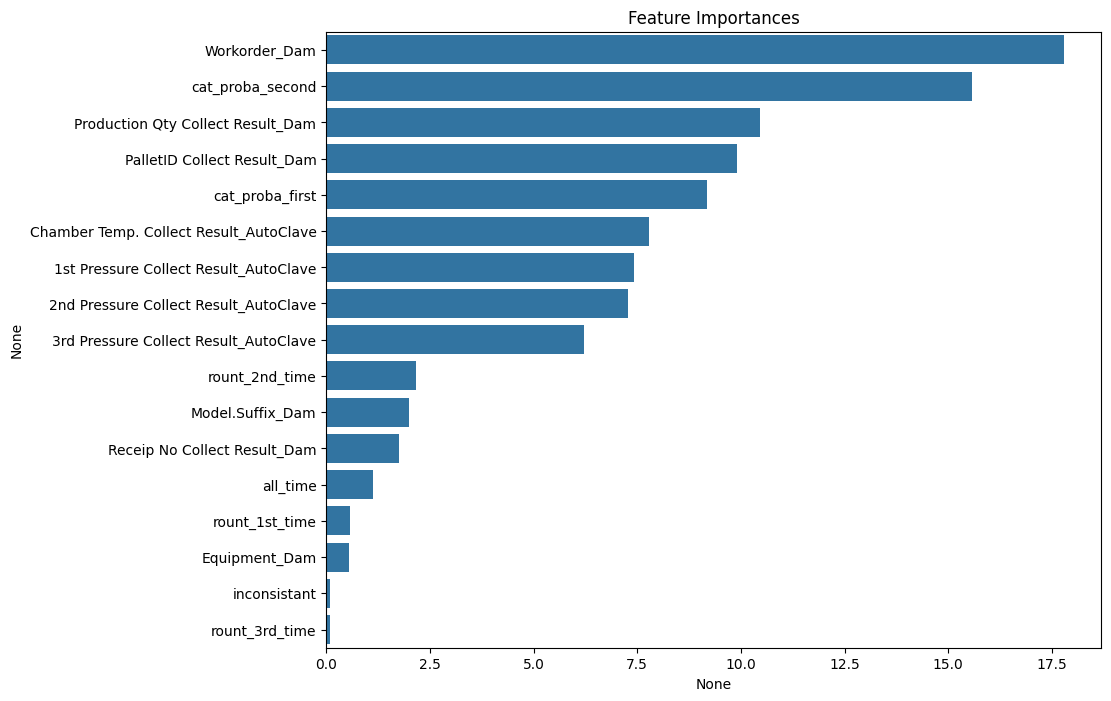

In [104]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(cat_best_model.feature_importances_, index=list(X_train_cat_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [105]:
# valid 확인하기
pred = cat_best_model.predict(X_valid_cat_last)
get_clf_eval(y_valid_cat_last, pred)

오차행렬:
 [[ 122  336]
 [  62 7582]]

정확도: 0.9509
정밀도: 0.6630
재현율: 0.2664
F1: 0.3801


In [106]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_cat, y_pred_custom_threshold_cat = model_best_threshold(cat_best_model, X_valid_cat_last, y_valid_cat_last)
get_clf_eval(y_valid_cat_last, y_pred_custom_threshold_cat)

오차행렬:
 [[ 186  272]
 [ 209 7435]]

정확도: 0.9406
정밀도: 0.4709
재현율: 0.4061
F1: 0.4361


In [107]:
# tmp
proba1 = cat_best_model.predict_proba(X_cat)[:, 1]

#### LGBM

In [108]:
lgbm_best_params["random_state"] = 42  # LightGBM에서는 random_state를 사용합니다.
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_train_lgbm_last, y_train_lgbm_last, categorical_feature=cat_features_indices_autoclave)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_state=42,
               reg_alpha=0.028967847134875147, reg_lambda=0.0010048404716309263,
               subsample=0.5695496693451576, subsample_freq=5)

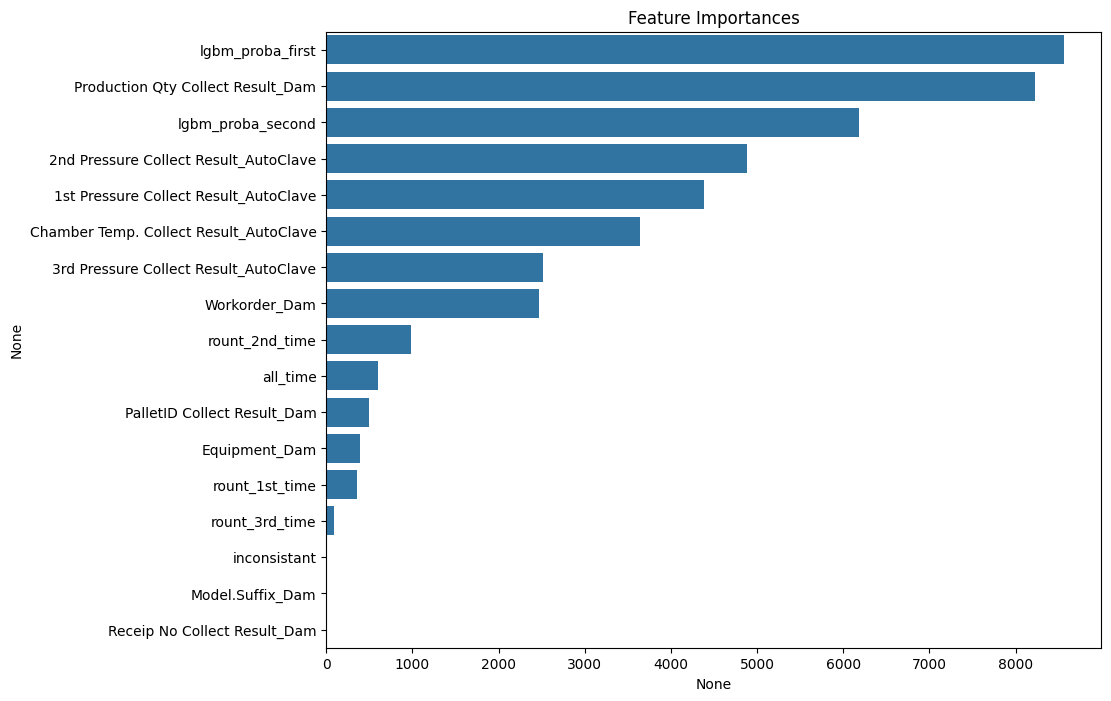

In [109]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(lgbm_best_model.feature_importances_, index=list(X_train_lgbm_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [110]:
pred = lgbm_best_model.predict(X_valid_lgbm_last)
get_clf_eval(y_valid_lgbm_last, pred)

오차행렬:
 [[ 409   49]
 [  25 7619]]

정확도: 0.9909
정밀도: 0.9424
재현율: 0.8930
F1: 0.9170


In [111]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_lgbm, y_pred_custom_threshold_lgbm = model_best_threshold(lgbm_best_model, X_valid_lgbm_last, y_valid_lgbm_last)
get_clf_eval(y_valid_lgbm_last, y_pred_custom_threshold_lgbm)

오차행렬:
 [[ 424   34]
 [  39 7605]]

정확도: 0.9910
정밀도: 0.9158
재현율: 0.9258
F1: 0.9207


In [112]:
proba2 = lgbm_best_model.predict_proba(X_lgbm)[:, 1]

#### XGB

In [113]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_state"] = 42
xgb_best_model = xgb.XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_train_xgb_last, y_train_xgb_last)

XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

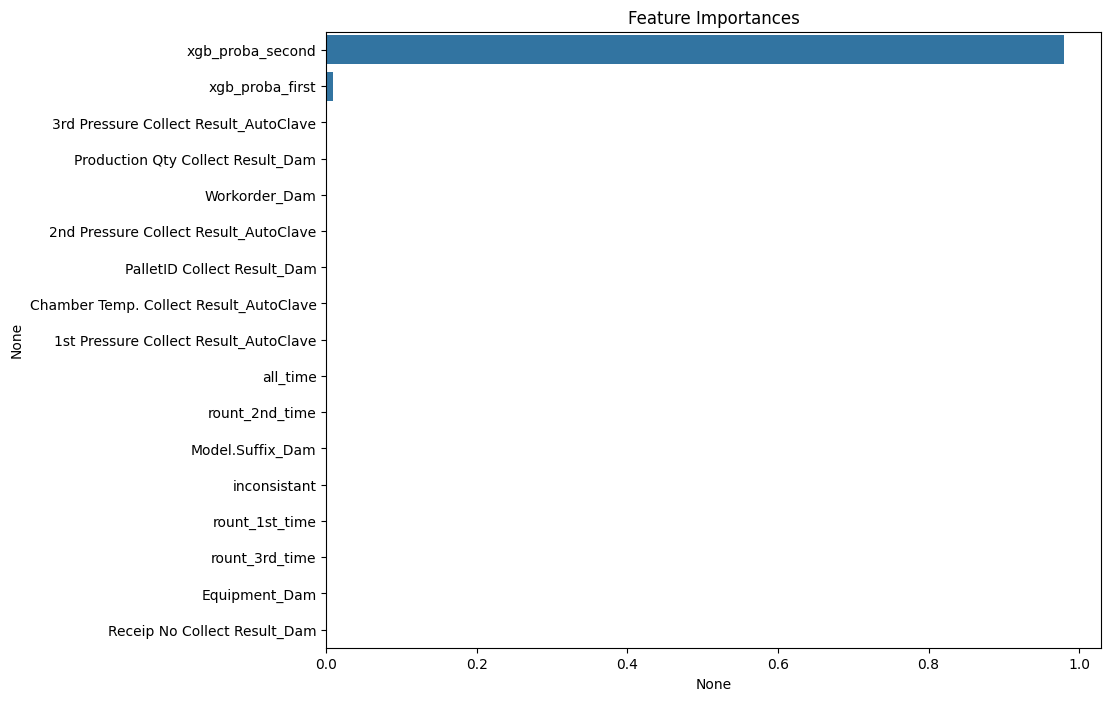

In [114]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train_xgb_last.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [115]:
pred = xgb_best_model.predict(X_valid_xgb_last)
get_clf_eval(y_valid_xgb_last, pred)

오차행렬:
 [[ 458    0]
 [   2 7642]]

정확도: 0.9998
정밀도: 0.9957
재현율: 1.0000
F1: 0.9978


In [116]:
# 최적의 threshold와 그 때의 예측 값 가져오기
threshold_xgb, y_pred_custom_threshold_xgb = model_best_threshold(xgb_best_model, X_valid_xgb_last, y_valid_xgb_last)
get_clf_eval(y_valid_xgb_last, y_pred_custom_threshold_xgb)

오차행렬:
 [[ 458    0]
 [   2 7642]]

정확도: 0.9998
정밀도: 0.9957
재현율: 1.0000
F1: 0.9978


In [117]:
proba3 = xgb_best_model.predict_proba(X_xgb)[:, 1]

## 6. Inference

### Catboost

In [137]:
# 최적의 하이퍼파라미터로 모델 재학습
cat_best_params["random_seed"] = 42
cat_best_model = CatBoostClassifier(**cat_best_params)
cat_best_model.fit(X_cat, y_cat, cat_features=cat_features_indices_autoclave)

0:	learn: 0.4926365	total: 85.7ms	remaining: 37.3s
1:	learn: 0.3741029	total: 127ms	remaining: 27.6s
2:	learn: 0.2954002	total: 183ms	remaining: 26.5s
3:	learn: 0.2475616	total: 263ms	remaining: 28.5s
4:	learn: 0.2131565	total: 338ms	remaining: 29.2s
5:	learn: 0.1982238	total: 374ms	remaining: 26.9s
6:	learn: 0.1869537	total: 455ms	remaining: 28s
7:	learn: 0.1771375	total: 472ms	remaining: 25.3s
8:	learn: 0.1705447	total: 542ms	remaining: 25.8s
9:	learn: 0.1664698	total: 615ms	remaining: 26.3s
10:	learn: 0.1629763	total: 695ms	remaining: 26.9s
11:	learn: 0.1604735	total: 730ms	remaining: 25.8s
12:	learn: 0.1589666	total: 774ms	remaining: 25.2s
13:	learn: 0.1573702	total: 859ms	remaining: 25.9s
14:	learn: 0.1561449	total: 945ms	remaining: 26.6s
15:	learn: 0.1557132	total: 1.02s	remaining: 26.9s
16:	learn: 0.1546805	total: 1.11s	remaining: 27.4s
17:	learn: 0.1539111	total: 1.19s	remaining: 27.7s
18:	learn: 0.1535093	total: 1.28s	remaining: 28.2s
19:	learn: 0.1527986	total: 1.36s	remainin

In [138]:
# pred
cat_pred = cat_best_model.predict(X_test_cat)

In [139]:
np.unique(cat_pred, return_counts = True)

(array([0, 1]), array([16781,   580]))

### LGBM

In [140]:
# 최적의 하이퍼파라미터로 모델 재학습
lgbm_best_params["random_seed"] = 42
lgbm_best_model = LGBMClassifier(**lgbm_best_params)
lgbm_best_model.fit(X_lgbm, y_lgbm, categorical_feature=cat_features_indices_autoclave)

LGBMClassifier(colsample_bytree=0.6246339245050061,
               learning_rate=0.009871149613069051, max_depth=43,
               min_child_samples=78, min_child_weight=1.0585590904879165,
               n_estimators=1325, num_leaves=61, random_seed=42,
               random_state=42, reg_alpha=0.028967847134875147,
               reg_lambda=0.0010048404716309263, subsample=0.5695496693451576,
               subsample_freq=5)

In [141]:
# pred
lgbm_pred = lgbm_best_model.predict(X_test_lgbm)

In [142]:
np.unique(lgbm_pred, return_counts = True)

(array([0, 1]), array([16765,   596]))

### XGB

In [143]:
# 최적의 하이퍼파라미터로 모델 재학습
xgb_best_params["random_seed"] = 42
xgb_best_model = XGBClassifier(**xgb_best_params)
xgb_best_model.fit(X_xgb, y_xgb)

/home/elicer/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.0011969062590495645, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7591416621317699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.6327155841428214,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.9526097633865376,
              learning_rate=0.9923011126856865, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=701, n_jobs=None, ...)

In [144]:
# pred
xgb_pred = xgb_best_model.predict(X_test_xgb)

In [145]:
np.unique(xgb_pred, return_counts = True)

(array([0, 1]), array([16520,   841]))

In [146]:
# best ensemble
best_f1 = 0
best_f1_t = 0
best_weights = None
best_weights_t = None

# 가중치 조합 테스트
for w1 in range(1, 10):
    for w2 in range(0, 10):
        for w3 in range(0, 10):
                # 가중 평균 계산
                final_proba = (w1 * proba1 + w2 * proba2 + w3 * proba3) / (w1 + w2 + w3)
                y_pred = (final_proba > 0.5).astype(int)
            
                # F1 스코어 계산
                f1 = f1_score(df_train['target'], y_pred)
                print(f1)
                
                # Threshold 스코어 계산
                precision, recall, thresholds = precision_recall_curve(df_train['target'], final_proba)
                f1_scores = 2*recall*precision / (recall + precision)
                best_threshold = thresholds[np.argmax(f1_scores)]
                y_pred_custom_threshold = (final_proba >= best_threshold).astype(int)
                f1_t = f1_score(df_train['target'], y_pred_custom_threshold)

                # 최고 성능 저장
                if f1 > best_f1:
                    best_f1 = f1
                    best_weights = (w1, w2, w3)
                
                if f1_t > best_f1_t:
                    best_f1_t = f1_t
                    best_weights_t = (w1, w2, w3)

print("Best F1 Score: ", best_f1)
print("Best Weights: ", best_weights)

0.584070796460177
0.9985084167909652
0.9993618379068284
0.9993618379068284
0.9993618379068284
0.9993618379068284
0.9993618379068284
0.9993618379068284
0.9993618379068284
0.9993618379068284
0.9447661469933186
0.9914310197086547
0.9995744680851064
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9753673292999135
0.988199957090753
0.9944468175993165
0.9995744680851064
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.978026712623869
0.9858551221603086
0.9910141206675225
0.9948739854762921
0.9997872793022761
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9791352979135298
0.9845758354755784
0.9886533932776708
0.992519769181449
0.9957319675629536
0.9997872793022761
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9995746490854955
0.9800128949065119
0.9843582601242769
0.98801882755669

In [147]:
# best ensemble 적용
cat = proba1 * 1
lgbm = proba2 * 7
xgb = proba3 * 8
y_best = (cat + lgbm + xgb)/(1 + 7 + 8)

In [148]:
precision, recall, thresholds = precision_recall_curve(df_train['target'], y_best)
f1_scores = 2*recall*precision / (recall + precision)
weights_best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_best >= weights_best_threshold).astype(int)
get_clf_eval(df_train['target'], y_pred_custom_threshold)

오차행렬:
 [[ 2350     0]
 [    1 38155]]

정확도: 1.0000
정밀도: 0.9996
재현율: 1.0000
F1: 0.9998


In [150]:
# proba
xgb_proba = xgb_best_model.predict_proba(X_test_xgb)[:, 1]
cat_proba = cat_best_model.predict_proba(X_test_cat)[:, 1]
lgbm_proba = lgbm_best_model.predict_proba(X_test_lgbm)[:, 1]

In [151]:
# 추론
cat = cat_proba * 1
lgbm = lgbm_proba * 7
xgb = xgb_proba * 8
p = (cat + lgbm + xgb)/(1 + 7 + 8)

In [152]:
p2 = np.where(p >= weights_best_threshold, 'AbNormal', 'Normal')

In [153]:
np.unique(p2, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  496, 16865]))

In [154]:
p3 = np.where(p >= 0.5, 'AbNormal', 'Normal')

In [155]:
np.unique(p3, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  699, 16662]))

## 7. Submission

In [157]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = p3

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [158]:
df_sub['target']

0          Normal
1          Normal
2        AbNormal
3          Normal
4          Normal
           ...   
17356      Normal
17357      Normal
17358      Normal
17359      Normal
17360      Normal
Name: target, Length: 17361, dtype: object

# 꼭 df_sub['target'] 확인하고 제출하시오